In [5]:
import sys
import glob
import os
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import ast
%matplotlib inline

# Get Order of MDSs

In [6]:
# read the log and extract the order of the MDSs
mdss = []
with open("logs/greedy-spill.log") as f:
    for line in f:
        if "fsmap e" in line:
            del mdss[:]
            for w in line.split()[-1].split('='):
                if "mds-" in w:
                    mdss.append(w.strip("mds-"))

labels = []
for i in range(0, len(mdss)):
    labels.append("MDS" + str(i))
    
mdss

['issdm-10', 'issdm-15', 'issdm-18', 'issdm-12']

# Per-MDS CPU Utilization

In [7]:
def plot_cpu(fname):
    trace = pd.read_table(fname, header=None, sep=(","),names=("seconds", "cpu"), skiprows=13)    
    hostname = os.path.basename(fname).strip('.out').strip('cpu-')
    ax.plot(trace['cpu'], linewidth=2.0, label="MDS" + str(mdss.index(hostname)))

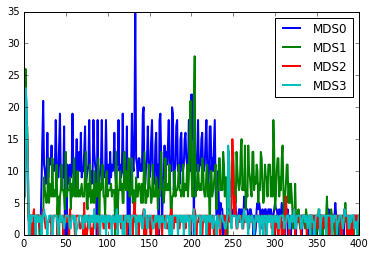

In [9]:
# plot the CPU utilizations in rank order
fig = plt.figure()
ax = fig.add_subplot(111)
for mds in mdss:
    for fname in glob.glob("utilization/cpu-*.out"):
        if mds in fname:
            plot_cpu(fname)

ax.set_xlim(0,400)
ax.legend()
plt.savefig('greedy-spill-cpu.png', dpi=300, bbox_inches='tight')

# Per-MDS Load

In [10]:
# parse MDS0's log
df = pd.DataFrame(columns=tuple(mdss))
with open("logs/issdm-10-daemon.log") as f:
    for line in f:
        if "load=" in line and "MDS" in line:
            words = line.split()
            for w in words:
                if "load=" in w:
                    if "MDS0" == words[words.index(w)-1]: 
                        temp = []
                    temp.append(w.split('=')[1])
                    if len(temp) >= len(mdss):
                        df.loc[len(df)] = temp

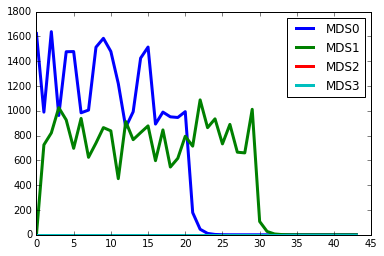

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(df, linewidth=3.0)
ax.legend(labels)
plt.savefig('greedy-spill-load.png', dpi=300, bbox_inches='tight')

# Per-MDS Request Throughput

In [12]:
def replace_zeros(vals):
    ret = []
    for x in vals:
        ret.append(float('nan')) if x == 0 else ret.append(x)
    return ret

def plot_reply(fname):
    trace = pd.read_table(fname, header=None, sep=(","),names=("seconds", "reply"), skiprows=13)    
    hostname = os.path.basename(fname).strip('.out').strip('reply-')    
    ax.plot(replace_zeros(trace['reply']), linewidth=2.0, label="MDS" + str(mdss.index(hostname)))

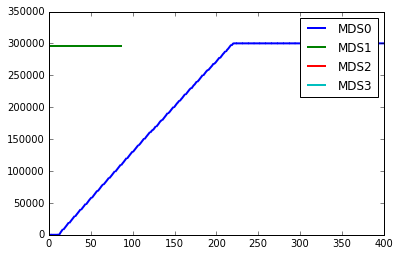

In [14]:
# plot the requests in rank order
fig = plt.figure()
ax = fig.add_subplot(111)
for mds in mdss:
    for fname in glob.glob("utilization/reply-issdm-*.out"):
        if mds in fname:
            plot_reply(fname)

ax.set_xlim(0,400)
ax.legend()
plt.savefig('greedy-spill-reply.png', dpi=300, bbox_inches='tight')